In [57]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns




from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier


from sklearn.model_selection import cross_validate

pd.set_option('max_columns', None)
pd.set_option("max_rows", 100)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-default-prediction/train.csv
/kaggle/input/credit-card-default-prediction/test.csv


In [3]:
train = pd.read_csv(r'/kaggle/input/credit-card-default-prediction/train.csv')
test = pd.read_csv(r'/kaggle/input/credit-card-default-prediction/test.csv')

In [4]:
def assign_columns(df, is_training=True):
    """Assign column names for the data set."""
    col_list = ['customer_id', 'credit_line', 'gender', 'education', 'marital_status', 'age',
                'pay_09_2005', 'pay_08_2005', 'pay_07_2005', 'pay_06_2005', 'pay_05_2005', 'pay_04_2005', 
                'bill_state_09_2005', 'bill_state_08_2005', 'bill_state_07_2005', 'bill_state_06_2005', 'bill_state_05_2005', 'bill_state_04_2005',
                'pay_amount_09_2005', 'pay_amount_08_2005', 'pay_amount_07_2005', 'pay_amount_06_2005', 'pay_amount_05_2005', 'pay_amount_04_2005',
                'is_default']
    if is_training:
        assert len(df.columns) == 25, 'number of column names not match...'
        df.columns = col_list
        
    else:
        assert len(df.columns) == 24, 'number of column names not match...'
        df.columns = col_list[:-1]
    
    return df

train = assign_columns(train)
test = assign_columns(test, is_training=False)

In [5]:
train.head()

,customer_id,credit_line,gender,education,marital_status,age,pay_09_2005,pay_08_2005,pay_07_2005,pay_06_2005,pay_05_2005,pay_04_2005,bill_state_09_2005,bill_state_08_2005,bill_state_07_2005,bill_state_06_2005,bill_state_05_2005,bill_state_04_2005,pay_amount_09_2005,pay_amount_08_2005,pay_amount_07_2005,pay_amount_06_2005,pay_amount_05_2005,pay_amount_04_2005,is_default
0,1,200000,2,3,1,53,0,0,0,0,0,0,126027,129008,130376,133207,136159,138741,6500,5000,5000,5100,5000,5400,0
1,2,130000,2,3,2,39,0,0,0,2,0,0,133825,134495,133745,130814,130758,123468,7500,10000,0,4500,4500,4179,0
2,3,350000,2,1,2,41,0,0,0,0,0,0,122017,121505,119522,119947,117328,118400,6000,5900,5800,4100,4500,5000,0
3,4,240000,2,2,1,43,1,-2,-2,-1,0,0,0,0,0,12700,12500,26225,0,0,12700,0,13725,0,0
4,5,180000,1,2,2,28,-1,-1,-1,-1,-1,-1,1832,0,832,332,416,416,0,416,332,500,3500,832,0


### Business Understanding

### Data Understanding & Processing

In [6]:
# customer - credit lines
cust_line = train.groupby(['customer_id'])['credit_line'].nunique().reset_index().rename(columns={'credit_line':'num_lines'})
print('The max number of credit lines a customer holds is', cust_line['num_lines'].max())

The max number of credit lines a customer holds is 1


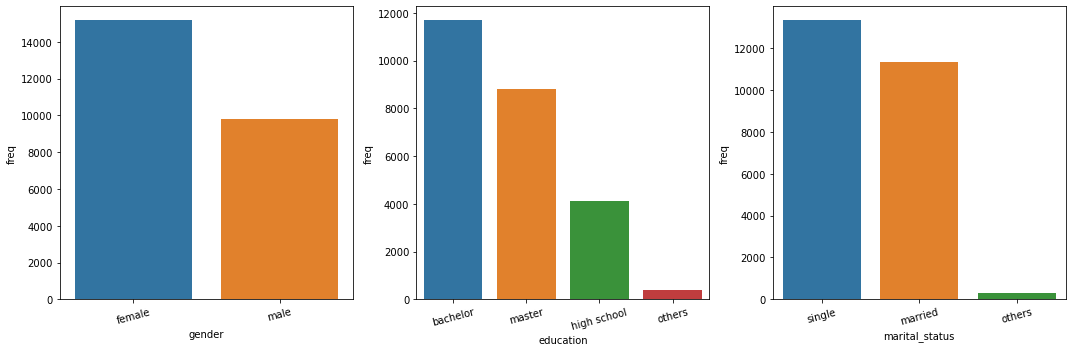

In [7]:
# gender, education, marital status 
# they all ordinal columns, to convert them into categorical features
train['gender'] = train['gender'].replace({1:'male', 2:'female'})
train['education'] = train['education'].replace({0:'others', 1:'master', 2:'bachelor', 3:'high school', 4:'others', 5:'others', 6:'others'})
train['marital_status'] = train['marital_status'].replace({0:'others', 1:'married', 2:'single', 3:'others'})

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.barplot(data=train['gender'].value_counts().reset_index().rename(columns={'index':'gender', 'gender':'freq'}), x='gender', y='freq', ax=ax1)
sns.barplot(data=train['education'].value_counts().reset_index().rename(columns={'index':'education', 'education':'freq'}), x='education', y='freq', ax=ax2)
sns.barplot(data=train['marital_status'].value_counts().reset_index().rename(columns={'index':'marital_status', 'marital_status':'freq'}), x='marital_status', y='freq', ax=ax3)

for ax in (ax1, ax2, ax3):
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=15)
fig.tight_layout()

<AxesSubplot:xlabel='age', ylabel='Count'>

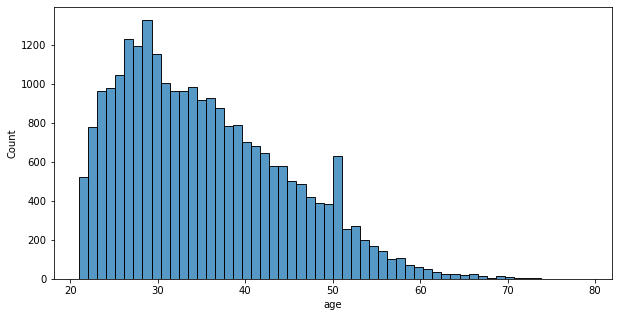

In [8]:
# age
assert train['age'].dtype == int

plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='age', bins=train['age'].nunique())

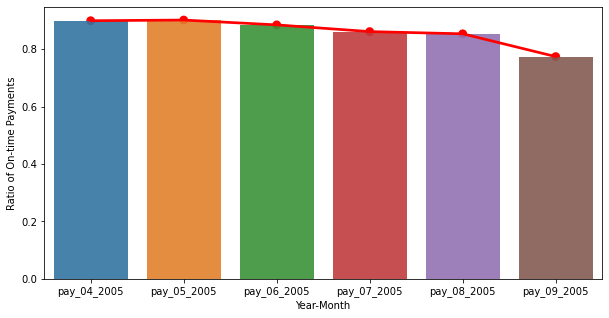

In [9]:
# pay, bill statement, pay amount
# note: payment follows the bill statement, usually payment on the following month means pay 2 month ahead
on_time_ratio = pd.DataFrame(np.zeros((6, 2)), columns=['y_m', 'pay_on_time'])
on_time_ratio['y_m'] = ['pay_04_2005', 'pay_05_2005', 'pay_06_2005', 'pay_07_2005', 'pay_08_2005', 'pay_09_2005']
on_time_ratio.iloc[0, 1] = train['pay_04_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[1, 1] = train['pay_05_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[2, 1] = train['pay_06_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[3, 1] = train['pay_07_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[4, 1] = train['pay_08_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]
on_time_ratio.iloc[5, 1] = train['pay_09_2005'].apply(lambda x: 'yes' if x <= 0 else 'no').value_counts(normalize=True)[0]

plt.figure(figsize=(10, 5))
sns.barplot(data=on_time_ratio, x='y_m', y='pay_on_time', alpha=0.9)
sns.pointplot(data=on_time_ratio, x='y_m', y='pay_on_time', color='red')
plt.xlabel('Year-Month')
plt.ylabel('Ratio of On-time Payments');

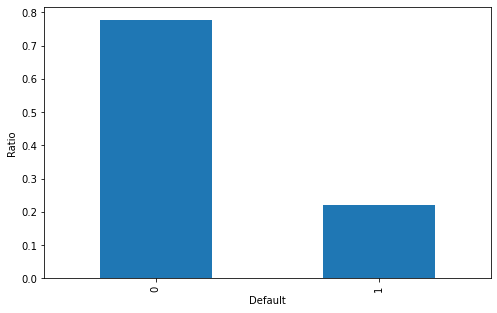

In [10]:
# default
plt.figure(figsize=(8, 5))
train['is_default'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Default')
plt.ylabel('Ratio');

### Modeling

In [11]:
# set customer id and credit line as index
try:
    train = train.set_index(keys=['customer_id', 'credit_line'])
except:
    pass

# convert categorical features into binary features
if 'gender_female' not in train.columns:
    train = pd.concat([train, pd.get_dummies(train[['gender', 'education', 'marital_status']])], axis=1)
    
# normalization & standardization

In [12]:
x_train, x_test, y_train, y_test = train_test_split(train.drop(columns=['gender', 'education', 'marital_status', 'is_default']),
                                                    train['is_default'],
                                                    test_size=0.2,
                                                    random_state=42)
print('x train shape =', x_train.shape)
print('x test shape =', x_test.shape)

x train shape = (20000, 28)
x test shape = (5000, 28)


In [41]:
metrics_list = [
                'accuracy', 
                'balanced_accuracy', 
                #'top_k_accuracy',
                'precision', 
                'average_precision', 
                'recall',
                'f1', 
                #'f1_micro', 
                #'f1_macro', 
                #'f1_weighted', 
                #'f1_samples',
                'roc_auc',
                # 'roc_auc_ovr', 
                #'roc_auc_ovo', 
                #'roc_auc_ovr_weighted', 
                #'roc_auc_ovo_weighted',
                'jaccard',
                #'brier_score_loss', 
                #'neg_log_loss'
               ]

- Baseline: Logistic Regression

In [42]:
lr = LogisticRegression(random_state=42, max_iter=5000)
cross_validate(lr, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.32773685, 0.25897169, 0.31924844, 0.58753157]),
 'score_time': array([0.02809834, 0.02948642, 0.02782488, 0.02873635]),
 'test_accuracy': array([0.7778, 0.7778, 0.7772, 0.7956]),
 'test_balanced_accuracy': array([0.50032148, 0.5       , 0.4996143 , 0.57445207]),
 'test_precision': array([0.5       , 0.        , 0.        , 0.64686469]),
 'test_average_precision': array([0.30740077, 0.3099678 , 0.30154144, 0.45562913]),
 'test_recall': array([0.00090009, 0.        , 0.        , 0.17641764]),
 'test_f1': array([0.00179695, 0.        , 0.        , 0.27722772]),
 'test_roc_auc': array([0.60701674, 0.60880963, 0.61086082, 0.69025216]),
 'test_jaccard': array([0.00089928, 0.        , 0.        , 0.16091954])}

- Baseline: Decision Tree

In [44]:
dt = DecisionTreeClassifier(random_state=42)
cross_validate(dt, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)

{'fit_time': array([0.40660453, 0.39788222, 0.39118934, 0.39878654]),
 'score_time': array([0.0322125 , 0.03157783, 0.03060842, 0.03092885]),
 'test_accuracy': array([0.7098, 0.7172, 0.714 , 0.709 ]),
 'test_balanced_accuracy': array([0.59516513, 0.60442282, 0.59561472, 0.59111461]),
 'test_precision': array([0.35880399, 0.37322176, 0.3635586 , 0.3549747 ]),
 'test_average_precision': array([0.27638587, 0.28426386, 0.27795193, 0.27395805]),
 'test_recall': array([0.38883888, 0.40144014, 0.38253825, 0.37893789]),
 'test_f1': array([0.37321814, 0.386817  , 0.37280702, 0.36656508]),
 'test_roc_auc': array([0.59613281, 0.60731554, 0.59814777, 0.59346772]),
 'test_jaccard': array([0.22942114, 0.23978495, 0.22911051, 0.22441365])}

- Baseline: Random Forest

In [46]:
rf = RandomForestClassifier(random_state=42)
cross_validate(rf, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)

{'fit_time': array([4.58754015, 4.62512398, 4.54672146, 4.52518153]),
 'score_time': array([0.26928258, 0.27786827, 0.26850057, 0.29820919]),
 'test_accuracy': array([0.8096, 0.8152, 0.8106, 0.8078]),
 'test_balanced_accuracy': array([0.64806874, 0.65777671, 0.64646124, 0.64337538]),
 'test_precision': array([0.62519685, 0.64496124, 0.63311688, 0.62057878]),
 'test_average_precision': array([0.52187784, 0.52923029, 0.51086107, 0.49659931]),
 'test_recall': array([0.35733573, 0.37443744, 0.3510351 , 0.34743474]),
 'test_f1': array([0.45475372, 0.4738041 , 0.45165026, 0.44547028]),
 'test_roc_auc': array([0.75179989, 0.75130807, 0.74983168, 0.74865756]),
 'test_jaccard': array([0.29429207, 0.31044776, 0.29169783, 0.28656273])}

- Baseline: Gradient Boosting

In [48]:
gbc = GradientBoostingClassifier(random_state=42)
cross_validate(gbc, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)

{'fit_time': array([6.20071578, 6.22479248, 6.57540822, 6.38340187]),
 'score_time': array([0.04568815, 0.04375029, 0.04828596, 0.04448771]),
 'test_accuracy': array([0.8178, 0.8196, 0.8206, 0.816 ]),
 'test_balanced_accuracy': array([0.6536615 , 0.65739042, 0.65706883, 0.6480037 ]),
 'test_precision': array([0.66778523, 0.67330017, 0.68074324, 0.66551127]),
 'test_average_precision': array([0.54501867, 0.5494096 , 0.54271597, 0.54422347]),
 'test_recall': array([0.35823582, 0.36543654, 0.36273627, 0.34563456]),
 'test_f1': array([0.46631517, 0.47374562, 0.47328244, 0.4549763 ]),
 'test_roc_auc': array([0.77118689, 0.77276338, 0.75953976, 0.7734488 ]),
 'test_jaccard': array([0.30404889, 0.31039755, 0.31      , 0.29447853])}

- Baseline: XGB

In [53]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, booster='gbtree')
cross_validate(xgb, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)

[07:00:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:00:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([2.12107706, 2.10067153, 2.12068272, 2.19762731]),
 'score_time': array([0.05007625, 0.04659939, 0.04741573, 0.05001569]),
 'test_accuracy': array([0.8074, 0.812 , 0.8102, 0.8096]),
 'test_balanced_accuracy': array([0.64472563, 0.64929008, 0.64749001, 0.64453249]),
 'test_precision': array([0.61671924, 0.63768116, 0.62939297, 0.62969005]),
 'test_average_precision': array([0.50662251, 0.51142882, 0.50753713, 0.50835081]),
 'test_recall': array([0.35193519, 0.35643564, 0.35463546, 0.34743474]),
 'test_f1': array([0.44813754, 0.45727483, 0.45365573, 0.44779582]),
 'test_roc_auc': array([0.74804006, 0.75078246, 0.74148265, 0.75124789]),
 'test_jaccard': array([0.288774  , 0.29640719, 0.29337305, 0.28849028])}

- Baseline: Light BGM

In [56]:
lgbm = LGBMClassifier(random_state=42)
cross_validate(lgbm, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)

{'fit_time': array([0.3348856 , 0.29986382, 0.29099512, 0.29820538]),
 'score_time': array([0.05616784, 0.05515027, 0.05338311, 0.05776644]),
 'test_accuracy': array([0.8182, 0.8176, 0.8156, 0.8156]),
 'test_balanced_accuracy': array([0.65359715, 0.65642622, 0.64806805, 0.65449759]),
 'test_precision': array([0.67060811, 0.66178862, 0.6626506 , 0.65217391]),
 'test_average_precision': array([0.54082853, 0.54317964, 0.53152662, 0.53639656]),
 'test_recall': array([0.35733573, 0.36633663, 0.34653465, 0.36453645]),
 'test_f1': array([0.46623605, 0.47161066, 0.45508274, 0.46766744]),
 'test_roc_auc': array([0.76686593, 0.76998419, 0.75797589, 0.76741908]),
 'test_jaccard': array([0.30398162, 0.3085671 , 0.29456771, 0.3051997 ])}

- Baseline: SVM

In [ ]:
svm = SVC(random_state=42)
cross_validate(svm, 
               X=x_train,
               y=y_train,
               scoring=metrics_list,
               cv=4)